In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import os
import time
import copy
from PIL import Image
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\sanzh\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\sanzh\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
BATCH_SIZE = 64
epochs = 30
TEST = "C:\\Users\\sanzh/Desktop/CHOC Data/test"
VAL = "C:\\Users\\sanzh/Desktop/CHOC Data/Val"
TRAIN_filter = "C:\\Users\\sanzh/Desktop/CHOC Data/train_pda_filtered"

In [3]:
transform_normalize = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.1295, 0.1322, 0.1428],
                                                        std = [0.1695, 0.1727, 0.1858])]) 

In [4]:
# Split train_filter data into training and validation set using 80-20 split

filtered = torchvision.datasets.ImageFolder(TRAIN_filter, transform = transform_normalize)
train_length = round(0.8*len(filtered))
val_length = len(filtered) - train_length
class_names = filtered.classes
train_data, val_data = torch.utils.data.random_split(filtered, [train_length, val_length])

In [5]:
# Initialize train and validation dataset and dataloaders

train_loader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)
val_loader = DataLoader(
    val_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [23]:
def train(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs = epochs):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    startTime = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            totalLoss = 0.0
            totalCorrect = 0
            if phase == 'train':
                model.train()
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True) :
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                    totalLoss += loss.item() * inputs.size(0)
                    totalCorrect += torch.sum(preds == labels.data)
                scheduler.step()
                epoch_loss = totalLoss/ len(trainloader.dataset)
                epoch_acc = totalCorrect.double()/len(trainloader.dataset)
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            if phase == 'val':
                model.eval()
                for inputs, labels in valloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    totalLoss += loss.item() * inputs.size(0)
                    totalCorrect += torch.sum(preds == labels.data)
                epoch_loss = totalLoss/ len(valloader.dataset)
                epoch_acc = totalCorrect.double()/len(valloader.dataset)
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()
    time_elapsed = time.time() - startTime
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return [train_loss, train_acc, val_loss, val_acc] 

In [25]:
# Loading model and setting parameters

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

Using cache found in C:\Users\sanzh/.cache\torch\hub\pytorch_vision_v0.10.0


In [27]:
metrics = train(model,  train_loader, val_loader, optimizer, criterion, scheduler, 30)

Epoch 0/29
----------
train Loss: 0.1755 Acc: 0.9291
val Loss: 0.0476 Acc: 0.9852

Epoch 1/29
----------
train Loss: 0.0274 Acc: 0.9926
val Loss: 0.0267 Acc: 0.9891

Epoch 2/29
----------
train Loss: 0.0106 Acc: 0.9978
val Loss: 0.0231 Acc: 0.9926

Epoch 3/29
----------
train Loss: 0.0057 Acc: 0.9991
val Loss: 0.0181 Acc: 0.9937

Epoch 4/29
----------
train Loss: 0.0040 Acc: 0.9991
val Loss: 0.0174 Acc: 0.9937

Epoch 5/29
----------
train Loss: 0.0028 Acc: 0.9996
val Loss: 0.0158 Acc: 0.9926

Epoch 6/29
----------
train Loss: 0.0019 Acc: 0.9998
val Loss: 0.0142 Acc: 0.9944

Epoch 7/29
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0145 Acc: 0.9940

Epoch 8/29
----------
train Loss: 0.0015 Acc: 0.9999
val Loss: 0.0145 Acc: 0.9940

Epoch 9/29
----------
train Loss: 0.0018 Acc: 0.9998
val Loss: 0.0141 Acc: 0.9944

Epoch 10/29
----------
train Loss: 0.0015 Acc: 0.9999
val Loss: 0.0142 Acc: 0.9944

Epoch 11/29
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0140 Acc: 0.9940

Ep

In [28]:
# Save Model
path = "C:\\Users\\sanzh/Desktop/models/mobileNet_v2.pt"
torch.save(model.state_dict(), path)

In [29]:
epochs_range = list(range(30))
train_acc = metrics[1]
train_acc = [i.item() for i in train_acc]
val_acc = metrics[3]
val_acc = [i.item() for i in val_acc]
train_loss = metrics[0]
val_loss = metrics[2]

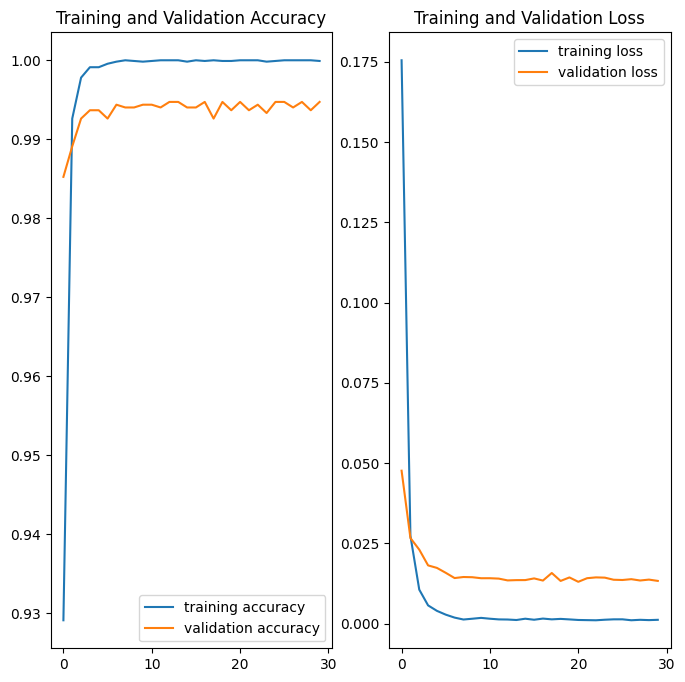

In [30]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label = "training accuracy")
plt.plot(epochs_range, val_acc, label = "validation accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='training loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Loading model

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 2)
path = "C:\\Users\\sanzh/Desktop/models/mobileNet_v2.pt"
model.load_state_dict(torch.load(path))
model.to(device)

Using cache found in C:\Users\sanzh/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [7]:
POS = "C:\\Users\\sanzh/Desktop/CHOC Data/test/POS"
NEG = "C:\\Users\\sanzh/Desktop/CHOC Data/test/NEG"

In [8]:
def createPathList(path):
    paths = []
    for root, dirs, files in os.walk(path):
        for d in dirs:
            paths.append(os.path.join(root, d))
    return paths

In [9]:
def createTestDataset(path, transform):
    images = {}
    path_list = createPathList(path)
    for clips in range(len(path_list)):
        clips_images = []
        for root, dirs, files in os.walk(path_list[clips]):
            for f in files:
                im = Image.open(os.path.join(root, f))
                input_tensor = transform(im)
                input_batch = input_tensor.unsqueeze(0)
                clips_images.append(input_batch)
        images[os.path.split(path_list[clips])[1]] = clips_images
    return images

In [10]:
def videoFramePaths(path):
    vid_dict = {}
    path_list = createPathList(path)
    for clips in range(len(path_list)):
        frame_paths = []
        for root, dirs, files in os.walk(path_list[clips]):
            for f in files:
                frame_paths.append(os.path.join(root, f))
        vid_dict[os.path.split(path_list[clips])[1]] = frame_paths
    return vid_dict

In [11]:
def getPredictions(model, dataset):
    keys = dataset.keys()
    pred_dict = {}
    for key in keys:
        clip_pred = []
        for frame in dataset[key]:
            with torch.no_grad():
                frame = frame.to(device)
                output = model(frame)
            _, pred = torch.max(output, 1)
            clip_pred.append(pred.cpu().item())
        pred_dict[key] = clip_pred
    return pred_dict

In [12]:
def predictPDA(preds, classes, alpha = 0.5):
    keys = preds.keys()
    pda_dict = {}
    for key in keys:
        ratio = sum(preds[key])/len(preds[key])
        if ratio > alpha:
            pda = classes[1]
        else:
            pda = classes[0]
        pda_dict[key] = pda
    return pda_dict

In [13]:
def countCorrect(preds, pda):
    counts = list(preds.values()).count(pda)
    print("Correctly predicted:", counts, "/", len(preds.values()))

In [14]:
# Create test datasets
pos_images = createTestDataset(POS, transform_normalize)
neg_images = createTestDataset(NEG, transform_normalize)

In [28]:
# Get predictions for each frame
pos_preds = getPredictions(model, pos_images)
neg_preds = getPredictions(model, neg_images)

In [29]:
# Predict PDA based on alpha threshold
pos_predicts = predictPDA(pos_preds, val_data.dataset.classes)
neg_predicts = predictPDA(neg_preds, val_data.dataset.classes)

In [30]:
# Count correctly predicted positive
countCorrect(pos_predicts, 'POS')

Correctly predicted: 23 / 34


In [31]:
# Count correctly predicted negative
countCorrect(neg_predicts, 'NEG')

Correctly predicted: 37 / 38
